In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy import stats
import japanize_matplotlib
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import lightgbm as lgb # LightGBMのインポートを追加
# LightGBMのインポートは元のコードの後半にもありますが、
# 念のため冒頭のインポート群に含めています。

# ===============================================================
# 関数定義
# ===============================================================
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.95):
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin = t_value * std / np.sqrt(n)
    return mean - margin, mean + margin

def handle_missing_val(df, features, enabled, min_horses):
    if not enabled:
        print("⚠ 欠損処理スキップ")
        return df

    print("欠損処理中...")
    processed_groups = []
    for race_id, group in df.groupby("race_id"):
        non_missing_mask = group[features].notnull().all(axis=1)
        if non_missing_mask.sum() < min_horses:
            continue
        for col in features:
            if group[col].isnull().any():
                group[col] = group[col].fillna(group[col].mean(skipna=True))
        processed_groups.append(group)
    df_processed = pd.concat(processed_groups, ignore_index=True)
    print(f"処理後: {len(df_processed)}件（元:{len(df)}）")
    return df_processed

def get_last_corner_position(row):
    for i in [4, 3, 2, 1]:
        val = row.get(f"position_{i}")
        if pd.notnull(val):
            return val
    return np.nan

# ===============================================================
# データ読み込み
# ===============================================================

# 頭数を混在させる
# target_num_horses = [8, 9, 10, 11, 12]
# 102, 301, 402は微妙なため除外
# target_course_ids = [
#     103, 201, 202, 302, 402,
#     501, 502, 601, 602, 700, 702, 802,
#     900, 901, 1001, 1002, 1201, 1304, 1400, 1402
# ]
target_num_horses = [11, 12]
target_course_ids = [1400, 1402]

course_label = "_".join(map(str, target_course_ids))
input_file = "input_全頭_編集後.csv"
df_all = pd.read_csv(input_file, encoding="utf-8")
df_all["race_date"] = pd.to_datetime(df_all["race_date"])
print(f"全データ: {len(df_all)}件")

# 並び替え
df_all = df_all.sort_values(["race_id", "horse_number"])

# ===============================================================
# ランニングスタイル判定（全期間・過去出走ベース）
# ===============================================================
print("🏇 ランニングスタイル（過去出走ベース）を算出中...")

# 最終コーナー順位
df_all["last_corner_position"] = df_all.apply(get_last_corner_position, axis=1)
df_all["last_corner_position_rate"] = df_all["last_corner_position"] / df_all["num_horses"]

# 時系列順
df_all = df_all.sort_values(["horse_id", "race_date"]).reset_index(drop=True)

# 過去平均通過順位率
def calc_past_avg(x):
    return x.expanding().mean().shift()

df_all["avg_last_corner_pos_rate_past"] = (
    df_all.groupby("horse_id", group_keys=False)["last_corner_position_rate"]
    .transform(calc_past_avg)
)

df_all["running_style_type_past"] = np.where(
    df_all["avg_last_corner_pos_rate_past"] < 0.5, "front",
    np.where(df_all["avg_last_corner_pos_rate_past"].notnull(), "back", np.nan)
)

# ===============================================================
# 対象コース×頭数に絞る
# ===============================================================
df_target = df_all[df_all["course_id"].isin(target_course_ids)].copy()
df_target = df_target[df_target["num_horses"].isin(target_num_horses)].copy()

# 欠損値補完
handle_missing = True
missing_check_features = ["time_index_average_2", "jockey_place_rate_100"]

df_target = handle_missing_val(
    df_target,
    features=missing_check_features,
    enabled=handle_missing,
    min_horses=2  # ★頭数を固定しないので最低2頭
)

# ===============================================================
# 特徴量作成
# ===============================================================

# (1) タイム指数平均との差
race_avg = df_target.groupby("race_id")["time_index_average_2"].transform("mean")
df_target["time_index_diff_from_avg"] = df_target["time_index_average_2"] - race_avg

# (2) 騎手勝率平均との差
race_avg = df_target.groupby("race_id")["jockey_place_rate_100"].transform("mean")
df_target["jockey_place_rate_diff_from_avg"] = df_target["jockey_place_rate_100"] - race_avg

# (3) 馬番別勝率
df_target["is_win"] = (df_target["finish_rank"] == 1).astype(int)
win_rate_by_horse_number = (
    df_target.groupby(["course_id", "horse_number"])["is_win"]
    .mean()
    .reset_index()
    .rename(columns={"is_win": "win_rate_by_course_horse_number"})
)
df_target = df_target.merge(win_rate_by_horse_number, on=["course_id", "horse_number"], how="left")
race_avg = df_target.groupby("race_id")["win_rate_by_course_horse_number"].transform("mean")
df_target["win_rate_by_course_horse_number_diff_from_avg"] = (
    df_target["win_rate_by_course_horse_number"] - race_avg
)

# (4) ランニングスタイル別勝率（コース×front/back）
horse_mean_style_rate = (
    df_all.groupby("horse_id")["last_corner_position_rate"]
    .mean()
    .reset_index()
    .rename(columns={"last_corner_position_rate": "mean_last_corner_pos_rate_all"})
)

horse_mean_style_rate["running_style_type_overall"] = np.where(
    horse_mean_style_rate["mean_last_corner_pos_rate_all"] < 0.5, "front", "back"
)

df_course = df_all[df_all["course_id"].isin(target_course_ids)].copy()

df_course = df_course.merge(
    horse_mean_style_rate[["horse_id", "running_style_type_overall"]],
    on="horse_id",
    how="left"
)

course_style_win_summary_target = (
    df_course.groupby(["course_id", "running_style_type_overall"])
    .agg(
        total_runs=("horse_id", "count"),
        total_wins=("finish_rank", lambda x: (x == 1).sum())
    )
    .reset_index()
)

course_style_win_summary_target["win_rate_overall"] = (
    course_style_win_summary_target["total_wins"] /
    course_style_win_summary_target["total_runs"]
)

df_target = df_target.merge(
    course_style_win_summary_target[
        ["course_id", "running_style_type_overall", "win_rate_overall"]
    ],
    left_on=["course_id", "running_style_type_past"],
    right_on=["course_id", "running_style_type_overall"],
    how="left"
)

df_target = df_target.drop(columns=["running_style_type_overall"])
df_target = df_target.rename(columns={"win_rate_overall": "running_style_win_prob"})

race_avg = df_target.groupby("race_id")["running_style_win_prob"].transform("mean")
df_target["running_style_win_prob_diff_from_avg"] = (
    df_target["running_style_win_prob"] - race_avg
)

# (5) 前方／後方の割合 × 勝率
df_course = df_all[df_all["course_id"].isin(target_course_ids)].copy()
df_course = df_course.merge(
    horse_mean_style_rate[["horse_id", "running_style_type_overall"]],
    on="horse_id",
    how="left"
)

race_style_counts = (
    df_course.groupby(["course_id", "race_id", "running_style_type_overall"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

race_style_counts["num_front"] = race_style_counts.get("front", 0)
race_style_counts["num_back"] = race_style_counts.get("back", 0)
race_style_counts["total"] = race_style_counts["num_front"] + race_style_counts["num_back"]
race_style_counts["ratio_front"] = race_style_counts["num_front"] / race_style_counts["total"]
race_style_counts["ratio_back"] = race_style_counts["num_back"] / race_style_counts["total"]

df_course = df_course.merge(
    race_style_counts[["course_id", "race_id", "ratio_front", "ratio_back"]],
    on=["course_id", "race_id"],
    how="left"
)

df_course["ratio_front_round"] = df_course["ratio_front"].round(2)
df_course["ratio_back_round"] = df_course["ratio_back"].round(2)

style_win_ratio_df = (
    df_course.groupby([
        "course_id", "running_style_type_overall",
        "ratio_front_round", "ratio_back_round"
    ])
    .agg(
        total_horses=("horse_id", "count"),
        total_wins=("finish_rank", lambda x: (x == 1).sum())
    )
    .reset_index()
)

style_win_ratio_df["win_rate"] = (
    style_win_ratio_df["total_wins"] / style_win_ratio_df["total_horses"]
)

race_style_counts = (
    df_target.groupby(["course_id", "race_id", "running_style_type_past"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

race_style_counts["num_front"] = race_style_counts.get("front", 0)
race_style_counts["num_back"] = race_style_counts.get("back", 0)
race_style_counts["total"] = race_style_counts["num_front"] + race_style_counts["num_back"]
race_style_counts["ratio_front"] = race_style_counts["num_front"] / race_style_counts["total"]
race_style_counts["ratio_back"] = race_style_counts["num_back"] / race_style_counts["total"]

race_style_counts["ratio_front_round"] = race_style_counts["ratio_front"].round(2)
race_style_counts["ratio_back_round"] = race_style_counts["ratio_back"].round(2)

df_target = df_target.merge(
    race_style_counts[["course_id", "race_id", "ratio_front_round", "ratio_back_round"]],
    on=["course_id", "race_id"],
    how="left"
)

df_target = df_target.merge(
    style_win_ratio_df[
        ["course_id", "running_style_type_overall",
         "ratio_front_round", "ratio_back_round", "win_rate"]
    ],
    left_on=["course_id", "running_style_type_past",
             "ratio_front_round", "ratio_back_round"],
    right_on=["course_id", "running_style_type_overall",
              "ratio_front_round", "ratio_back_round"],
    how="left"
)

df_target = df_target.rename(columns={"win_rate": "style_win_prob_by_ratio"})
df_target = df_target.drop(columns=["running_style_type_overall"])

race_avg = df_target.groupby("race_id")["style_win_prob_by_ratio"].transform("mean")
df_target["style_win_prob_by_ratio_diff_from_avg"] = (
    df_target["style_win_prob_by_ratio"] - race_avg
)

# ===============================================================
# 相互作用項作成
# ===============================================================
df_target["time_index_diff_from_avg_and_jockey_place_rate_diff_from_avg"] = (
    df_target["time_index_diff_from_avg"] * df_target["jockey_place_rate_diff_from_avg"]
)

df_target["time_index_diff_from_avg_and_win_rate_by_course_horse_number"] = (
    df_target["time_index_diff_from_avg"] * df_target["win_rate_by_course_horse_number"]
)

df_target["time_index_diff_from_avg_and_running_style_win_prob"] = (
    df_target["time_index_diff_from_avg"] * df_target["running_style_win_prob"]
)

df_target["time_index_diff_from_avg_and_style_win_prob_by_ratio"] = (
    df_target["time_index_diff_from_avg"] * df_target["style_win_prob_by_ratio"]
)

df_target["jockey_place_rate_diff_from_avg_and_win_rate_by_course_horse_number"] = (
    df_target["jockey_place_rate_diff_from_avg"] * df_target["win_rate_by_course_horse_number"]
)

df_target["jockey_place_rate_diff_from_avg_and_running_style_win_prob"] = (
    df_target["jockey_place_rate_diff_from_avg"] * df_target["running_style_win_prob"]
)

df_target["jockey_place_rate_diff_from_avg_and_style_win_prob_by_ratio"] = (
    df_target["jockey_place_rate_diff_from_avg"] * df_target["style_win_prob_by_ratio"]
)

df_target["win_rate_by_course_horse_number_and_running_style_win_prob"] = (
    df_target["win_rate_by_course_horse_number"] * df_target["running_style_win_prob"]
)

df_target["win_rate_by_course_horse_number_and_style_win_prob_by_ratio"] = (
    df_target["win_rate_by_course_horse_number"] * df_target["style_win_prob_by_ratio"]
)

df_target["running_style_win_prob_and_style_win_prob_by_ratio"] = (
    df_target["running_style_win_prob"] * df_target["style_win_prob_by_ratio"]
)

全データ: 634887件
🏇 ランニングスタイル（過去出走ベース）を算出中...
欠損処理中...
処理後: 13504件（元:13947）


In [3]:
# ===============================================================
# 特徴量リスト
# ===============================================================
features = [
    "time_index_diff_from_avg",
    "jockey_place_rate_diff_from_avg",
#    "win_rate_by_course_horse_number",
#    "running_style_win_prob",
#    "style_win_prob_by_ratio",
    "win_rate_by_course_horse_number_diff_from_avg",
    "running_style_win_prob_diff_from_avg",
    "style_win_prob_by_ratio_diff_from_avg",
    "num_horses",
    # ここから相互作用項
#    "time_index_diff_from_avg_and_jockey_place_rate_diff_from_avg",
#    "time_index_diff_from_avg_and_win_rate_by_course_horse_number",
#    "time_index_diff_from_avg_and_running_style_win_prob",
#    "time_index_diff_from_avg_and_style_win_prob_by_ratio",
#    "jockey_place_rate_diff_from_avg_and_win_rate_by_course_horse_number",
#    "jockey_place_rate_diff_from_avg_and_running_style_win_prob",
#    "jockey_place_rate_diff_from_avg_and_style_win_prob_by_ratio",
#    "win_rate_by_course_horse_number_and_running_style_win_prob",
#    "win_rate_by_course_horse_number_and_style_win_prob_by_ratio",
#    "running_style_win_prob_and_style_win_prob_by_ratio",
]

# ===============================================================
# ★ ラベル作成（相対順位 finish_rank / num_horses）
# ===============================================================
df_target["relative_rank"] = df_target["finish_rank"] / df_target["num_horses"]
df_target["is_top_half"] = (df_target["relative_rank"] <= 0.5).astype(int)

# ===============================================================
# Walk-Forward 設定
# ===============================================================
start_year = 2021
end_year = 2024
num_train_races = 300
bet_amount = 100

all_course_pop_stats = []
all_wf_predictions = []

# ===============================================================
# 🔁 各コースごとに Walk-Forward (XGBoost)
# ===============================================================
for course_id in target_course_ids:

    print("\n" + "="*70)
    print(f"🚩 コース {course_id} の Walk-Forward を開始 (XGBoost)")
    print("="*70)

    df_course = df_target[
        (df_target["course_id"] == course_id) &
        (df_target["race_date"].dt.year >= start_year) &
        (df_target["race_date"].dt.year <= end_year)
    ].copy()

    if df_course.empty:
        print(f"⚠ コース {course_id} のデータがありません。スキップします")
        continue

    df_course = df_course.sort_values(["race_date", "race_id", "horse_number"]).reset_index(drop=True)
    race_ids = df_course["race_id"].unique()

    if len(race_ids) <= num_train_races:
        print(f"⚠ レース数不足のためスキップ（{len(race_ids)}件）")
        continue

    print(f"対象レース数: {len(race_ids)}")
    print("Walk-Forward 予測を開始します...\n")

    wf_predictions = []

    for i in tqdm(range(num_train_races, len(race_ids)),
                  desc=f"Course {course_id} Progress (XGB)"):

        train_races = race_ids[:i]
        val_race = race_ids[i]

        df_train = df_course[df_course["race_id"].isin(train_races)].copy()
        df_val = df_course[df_course["race_id"] == val_race].copy()

        df_train_filtered = df_train[~df_train["popularity"].isin([1])]

        X_train = df_train_filtered[features]
        y_train = (df_train_filtered["relative_rank"] <= 0.5).astype(int)

        X_val = df_val[features]

        # XGBoost モデル
        model_wf = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            subsample=0.8,
            colsample_bytree=0.8,
            base_score=0.5,
            max_depth=3,
            learning_rate=0.06,
            n_estimators=100,
            reg_alpha=0.5,
            reg_lambda=1.0,
        )

        model_wf.fit(X_train, y_train)

        df_val["pred_prob"] = model_wf.predict_proba(X_val)[:, 1]
        df_val = df_val.sort_values("pred_prob", ascending=False)
        df_val["selected"] = 0

        # ★ 各レースの頭数に応じて「上位半分」を選ぶ
        num_select = int(df_val["num_horses"].iloc[0] / 2)
        df_val.iloc[:num_select, df_val.columns.get_loc("selected")] = 1

        wf_predictions.append(df_val)

    wf_pred_df = pd.concat(wf_predictions, ignore_index=True)
    all_wf_predictions.append(wf_pred_df)

    print(f"✅ コース {course_id} の Walk-Forward 完了！")

    # ===============================================================
    # 人気別成績（1着のみ）
    # ===============================================================
    df_pred_top1 = wf_pred_df.loc[
        wf_pred_df.groupby("race_id")["pred_prob"].idxmax()
    ].copy()

    df_pred_top1["is_hit"] = (df_pred_top1["finish_rank"] == 1).astype(int)
    df_pred_top1["payout"] = df_pred_top1["is_hit"] * df_pred_top1["odds"] * bet_amount

    # ▼ 頭数ごとの集計
    for nh in sorted(df_pred_top1["num_horses"].unique()):
        df_nh = df_pred_top1[df_pred_top1["num_horses"] == nh].copy()
    
        print(f"\n\n📉 コース {course_id} / {nh}頭 の人気別成績")
        print("="*60)
    
        pop_stats = (
            df_nh.groupby("popularity")
            .agg(
                total_pred=("is_hit", "count"),
                hits=("is_hit", "sum"),
                total_payout=("payout", "sum"),
            )
        )
    
        # 人気の抜け番号を補完（1〜最大人気）
        max_pop = int(df_nh["popularity"].max())
        pop_stats = pop_stats.reindex(range(1, max_pop + 1), fill_value=0).reset_index()
        pop_stats.rename(columns={"index": "popularity"}, inplace=True)
    
        pop_stats["total_bet"] = pop_stats["total_pred"] * bet_amount
        pop_stats["accuracy"] = pop_stats["hits"] / pop_stats["total_pred"].replace(0, pd.NA)
        pop_stats["roi"] = pop_stats["total_payout"] / pop_stats["total_bet"].replace(0, pd.NA)
    
        print(pop_stats)
    
        # 保存（必要ならリストへ）
        pop_stats["course_id"] = course_id
        pop_stats["num_horses"] = nh
        all_course_pop_stats.append(pop_stats)

# ===============================================================
# 🔹 全コースまとめ 人気別成績（1着のみ・頭数別）
# ===============================================================
wf_pred_all_courses = pd.concat(all_wf_predictions, ignore_index=True)

df_pred_top1_all = wf_pred_all_courses.loc[
    wf_pred_all_courses.groupby("race_id")["pred_prob"].idxmax()
].copy()

df_pred_top1_all["is_hit"] = (df_pred_top1_all["finish_rank"] == 1).astype(int)
df_pred_top1_all["payout"] = df_pred_top1_all["is_hit"] * df_pred_top1_all["odds"] * bet_amount

print("\n\n======================================")
print("🏇 全コース × 頭数 × 人気別成績まとめ（1着のみ）")
print("======================================")

for nh in sorted(df_pred_top1_all["num_horses"].unique()):
    df_nh = df_pred_top1_all[df_pred_top1_all["num_horses"] == nh].copy()

    print(f"\n★ {nh}頭 レース")
    print("-"*40)

    pop_stats_all = (
        df_nh.groupby("popularity")
        .agg(
            total_pred=("is_hit", "count"),
            hits=("is_hit", "sum"),
            total_payout=("payout", "sum"),
        )
    )

    max_pop = int(df_nh["popularity"].max())
    pop_stats_all = pop_stats_all.reindex(range(1, max_pop + 1), fill_value=0).reset_index()
    pop_stats_all.rename(columns={"index": "popularity"}, inplace=True)

    pop_stats_all["total_bet"] = pop_stats_all["total_pred"] * bet_amount
    pop_stats_all["accuracy"] = pop_stats_all["hits"] / pop_stats_all["total_pred"].replace(0, pd.NA)
    pop_stats_all["roi"] = pop_stats_all["total_payout"] / pop_stats_all["total_bet"].replace(0, pd.NA)

    print(pop_stats_all)


# ===============================================================
# ★ 【修正箇所】 LightGBMの処理前のデータ準備
# df_target に XGBoostの予測結果 (pred_prob) をマージ
# ===============================================================

# XGBoostの予測結果から、マージに必要なカラムを抽出
# wf_pred_all_courses には、race_id, horse_number, pred_prob が含まれている
xgb_pred_for_merge = wf_pred_all_courses[["race_id", "horse_number", "pred_prob"]].copy()

# df_target に pred_prob をマージして追加
# LightGBMのWalk-Forwardはdf_targetをベースに行うため、ここでpred_probを持たせておく
df_target = df_target.merge(
    xgb_pred_for_merge,
    on=["race_id", "horse_number"],
    how="left"
)


🚩 コース 1400 の Walk-Forward を開始 (XGBoost)
対象レース数: 490
Walk-Forward 予測を開始します...



Course 1400 Progress (XGB): 100%|████████████████████████████████████████████████████| 190/190 [00:15<00:00, 12.03it/s]


✅ コース 1400 の Walk-Forward 完了！


📉 コース 1400 / 11頭 の人気別成績
   popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0           1          23     7        1010.0       2300  0.304348   0.43913
1           2          15     3        1010.0       1500       0.2  0.673333
2           3           5     0           0.0        500       0.0       0.0
3           4           6     1         550.0        600  0.166667  0.916667
4           5           4     0           0.0        400       0.0       0.0
5           6           2     0           0.0        200       0.0       0.0
6           7           1     0           0.0        100       0.0       0.0
7           8           0     0           0.0          0      <NA>      <NA>
8           9           0     0           0.0          0      <NA>      <NA>
9          10           1     0           0.0        100       0.0       0.0


📉 コース 1400 / 12頭 の人気別成績
   popularity  total_pred  hits  total_payout  total_bet  accuracy     

Course 1402 Progress (XGB): 100%|████████████████████████████████████████████████████| 187/187 [00:15<00:00, 12.26it/s]


✅ コース 1402 の Walk-Forward 完了！


📉 コース 1402 / 11頭 の人気別成績
   popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0           1          25    11        1790.0       2500      0.44     0.716
1           2          15     2         580.0       1500  0.133333  0.386667
2           3           6     2         980.0        600  0.333333  1.633333
3           4           7     1         900.0        700  0.142857  1.285714
4           5           4     0           0.0        400       0.0       0.0
5           6           1     0           0.0        100       0.0       0.0
6           7           1     0           0.0        100       0.0       0.0
7           8           0     0           0.0          0      <NA>      <NA>
8           9           1     0           0.0        100       0.0       0.0


📉 コース 1402 / 12頭 の人気別成績
   popularity  total_pred  hits  total_payout  total_bet accuracy       roi
0           1          48    21        3830.0       4800   0.4375  0.797

In [5]:
# ===============================================================
# LightGBMによるパーセンタイル予測
# ===============================================================

# ===============================================================
# パラメータ
# ===============================================================
percentiles = [75]
exclude_popularities = [1]

all_course_predictions = []

for course_id in target_course_ids:

    print("\n" + "="*70)
    print(f"🚩 コース {course_id} の Walk-Forward を開始 (LightGBM)")
    print("="*70)

    # --------------------------------------------------------------
    # コース別データ抽出
    # --------------------------------------------------------------
    # df_target は既に pred_prob を含んでいる
    df_course = df_target[
        (df_target["course_id"] == course_id) &
        (df_target["race_date"].dt.year >= start_year) &
        (df_target["race_date"].dt.year <= end_year)
    ].copy()

    if df_course.empty:
        print(f"⚠ コース {course_id} のデータがありません。スキップします")
        continue

    df_course = df_course.sort_values(["race_date", "race_id", "horse_number"]).reset_index(drop=True)
    race_ids = df_course["race_id"].unique()

    if len(race_ids) <= num_train_races:
        print(f"⚠ コース {course_id} のレース数が少ないためスキップ（{len(race_ids)}件）")
        continue

    wf_predictions = []

    # --------------------------------------------------------------
    # Walk-Forward Loop
    # --------------------------------------------------------------
    for i in tqdm(range(num_train_races, len(race_ids)), desc=f"Course {course_id} Progress (LGB)"):

        train_races = race_ids[:i]
        val_race = race_ids[i]

        df_train = df_course[df_course["race_id"].isin(train_races)].copy()
        df_val = df_course[df_course["race_id"] == val_race].copy() # df_val には pred_prob が含まれる

        # 人気1除外（学習のみ）
        df_train_filtered = df_train[~df_train["popularity"].isin(exclude_popularities)]

        X_train = df_train_filtered[features]
        y_train = df_train_filtered["relative_rank"]
        X_val = df_val[features]

        # ------------------------
        # パーセンタイルごとにモデル学習
        # ------------------------
        preds_dict = {}
        for q in percentiles:
            alpha = q / 100
            model_q = lgb.LGBMRegressor(
                objective='quantile',
                alpha=alpha,
                n_estimators=1000,
                learning_rate=0.05,
                max_depth=3,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                verbose=-1,        # Python 側のverbose
                silent=True,       # 古いバージョンで有効
            )
            model_q.fit(X_train, y_train)
            preds_dict[q] = model_q.predict(X_val)

        # ------------------------
        # 予測値を df_val に追加
        # ------------------------
        for q in percentiles:
            df_val[f"pred_{q}th"] = preds_dict[q]

        wf_predictions.append(df_val) # df_val には pred_prob と LightGBMの予測値が含まれる

    # コース別全予測を結合
    wf_pred_df = pd.concat(wf_predictions, ignore_index=True)
    all_course_predictions.append(wf_pred_df)

    print(f"✅ コース {course_id} の Walk-Forward 完了！")

# ===============================================================
# 🔹 全コースまとめ (full_pred_df に pred_prob が含まれる)
# ===============================================================
full_pred_df = pd.concat(all_course_predictions, ignore_index=True)
print(full_pred_df.head())

# 出力確認
full_pred_df.to_csv(f"C:\\Users\\ryo\\Downloads\\full_pred_df.csv", index=False, encoding="utf-8-sig")


🚩 コース 1400 の Walk-Forward を開始 (LightGBM)


Course 1400 Progress (LGB): 100%|████████████████████████████████████████████████████| 190/190 [01:01<00:00,  3.08it/s]


✅ コース 1400 の Walk-Forward 完了！

🚩 コース 1402 の Walk-Forward を開始 (LightGBM)


Course 1402 Progress (LGB): 100%|████████████████████████████████████████████████████| 187/187 [00:59<00:00,  3.12it/s]


✅ コース 1402 の Walk-Forward 完了！
     race_id  horse_number       race      horse_id jockey_id  frame_number  \
0  231004B09             1  231004B09  2.020102e+09      5512             1   
1  231004B09             2  231004B09  2.020106e+09      5389             2   
2  231004B09             3  231004B09  2.018103e+09      5653             3   
3  231004B09             4  231004B09  2.019100e+09      5592             4   
4  231004B09             5  231004B09  2.017104e+09      5608             5   

   style   odds  popularity  finish_rank  ...  \
0    3.0    5.9         2.0          2.0  ...   
1    1.0    1.2         1.0          1.0  ...   
2    3.0   87.9         8.0          8.0  ...   
3    2.0   21.6         4.0          9.0  ...   
4    3.0  177.4        10.0          3.0  ...   

   jockey_place_rate_diff_from_avg_and_win_rate_by_course_horse_number  \
0                                           0.000351                     
1                                           0.012131



📊 閾値分析開始: 頭数=12頭, 人気=4番人気, フィルタ項目=pred_75th
閾値を変化させながら成績を集計中...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 402.89it/s]


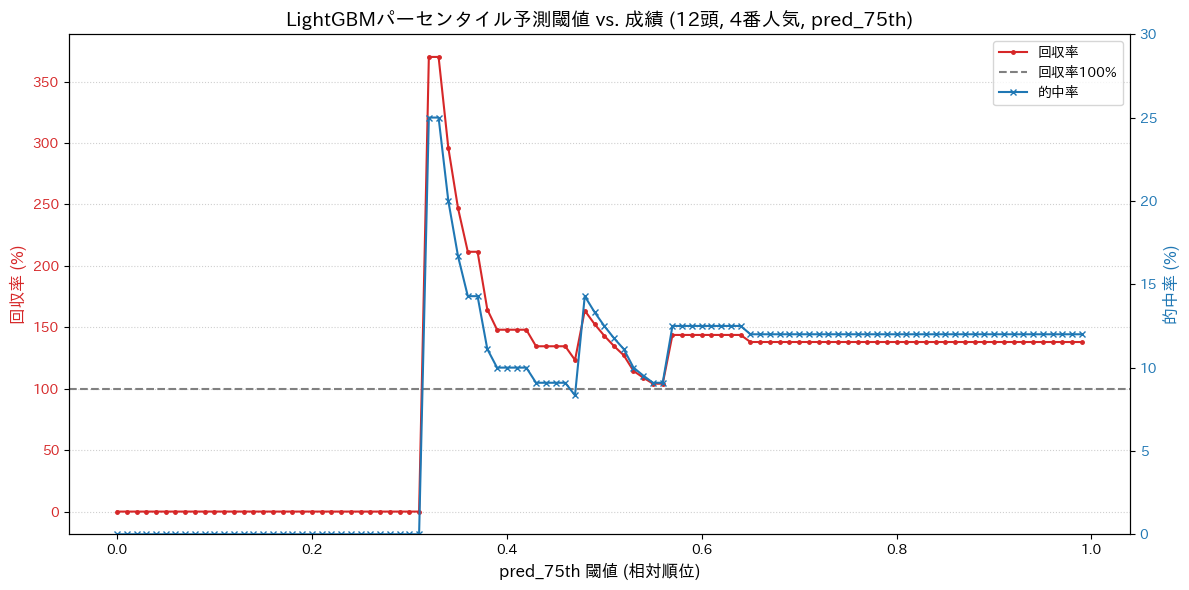

In [11]:
# ===============================================================
# 📊 【追加機能】 LightGBMの閾値分析とグラフ描画
# ===============================================================

# --- ユーザーが指定するパラメータ ---
# グラフ描画対象の頭数
TARGET_NUM_HORSES = 12
# グラフ描画対象の人気 (例: 2番人気を対象とする場合)
TARGET_POPULARITY = 4
# フィルタリングに使用するLightGBMのパーセンタイル予測 (例: 'pred_25th' or 'pred_75th')
TARGET_PERCENTILE_COL = "pred_75th"
# 100円あたりの払い戻し（コードのbet_amountに合わせる）
BET_AMOUNT = 100

def analyze_and_plot_threshold_performance(
    df_full: pd.DataFrame,
    num_horses: int,
    popularity: int,
    percentile_col: str,
    bet_amount: int
):
    """
    LightGBMのパーセンタイル予測値を閾値とした場合の的中率・回収率を計算し、グラフ化する関数。
    """
    print(f"\n\n=======================================================")
    print(f"📊 閾値分析開始: 頭数={num_horses}頭, 人気={popularity}番人気, フィルタ項目={percentile_col}")
    print(f"=======================================================")

    # 1. 各レースでpred_probが最高の馬（1着予想馬）を抽出
    # full_pred_df には pred_prob が含まれている前提
    if "pred_prob" not in df_full.columns:
        print("致命的エラー: 'pred_prob' カラムが full_pred_df に見つかりません。マージ処理を確認してください。")
        return

    df_pred_top1 = df_full.loc[
        df_full.groupby("race_id")["pred_prob"].idxmax()
    ].copy()

    # 2. 対象の頭数と人気でフィルタリング
    df_filtered = df_pred_top1[
        (df_pred_top1["num_horses"] == num_horses) &
        (df_pred_top1["popularity"] == popularity)
    ].copy()

    if df_filtered.empty:
        print("⚠ 該当する条件のデータがありませんでした。分析をスキップします。")
        return

    # 閾値を0.01刻みで生成 (相対順位なので0～1の範囲)
    thresholds = np.arange(0.0, 1.0, 0.01)

    results = []

    # 3. 閾値を変化させて成績を集計
    print("閾値を変化させながら成績を集計中...")
    for threshold in tqdm(thresholds):
        # LightGBM予測値が閾値以下の場合に購入 (relative_rankは小さい方が好成績なので「以下」)
        df_buy = df_filtered[df_filtered[percentile_col] <= threshold].copy()

        total_pred = len(df_buy)
        total_bet = total_pred * bet_amount
        hits = (df_buy["finish_rank"] == 1).sum()

        # 払い戻し額 (1着の場合のみオッズが有効)
        df_buy["is_hit"] = (df_buy["finish_rank"] == 1).astype(int)
        total_payout = (df_buy["is_hit"] * df_buy["odds"] * bet_amount).sum()

        if total_pred > 0:
            accuracy = hits / total_pred
            roi = total_payout / total_bet
        else:
            accuracy = 0.0
            roi = 0.0

        results.append({
            "threshold": threshold,
            "total_pred": total_pred,
            "accuracy": accuracy * 100, # %表示に
            "roi": roi * 100,           # %表示に
        })

    df_results = pd.DataFrame(results)

    # 5. グラフの描画
    fig, ax1 = plt.subplots(figsize=(12, 6))
    japanize_matplotlib.japanize() # 日本語対応

    # 回収率 (左Y軸)
    color = 'tab:red'
    ax1.set_xlabel(f'{percentile_col} 閾値 (相対順位)', fontsize=12)
    ax1.set_ylabel('回収率 (%)', color=color, fontsize=12)
    ax1.plot(df_results["threshold"], df_results["roi"], color=color, label='回収率', marker='.', markersize=5)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(100, color='gray', linestyle='--', label='回収率100%') # 回収率100%ライン
    ax1.grid(axis='y', linestyle=':', alpha=0.6)

    # 的中率 (右Y軸)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('的中率 (%)', color=color, fontsize=12)
    ax2.plot(df_results["threshold"], df_results["accuracy"], color=color, label='的中率', marker='x', markersize=5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, max(df_results["accuracy"]) * 1.2) # 的中率の最大値に合わせてY軸を調整

    # タイトルと凡例
    title = f"LightGBMパーセンタイル予測閾値 vs. 成績 ({num_horses}頭, {popularity}番人気, {percentile_col})"
    plt.title(title, fontsize=14)
    
    # 凡例をまとめる
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    fig.tight_layout()
    plt.show()

# ---------------------------------------------------------------
# 実行
# ---------------------------------------------------------------

analyze_and_plot_threshold_performance(
    df_full=full_pred_df,
    num_horses=TARGET_NUM_HORSES,
    popularity=TARGET_POPULARITY,
    percentile_col=TARGET_PERCENTILE_COL,
    bet_amount=BET_AMOUNT
)

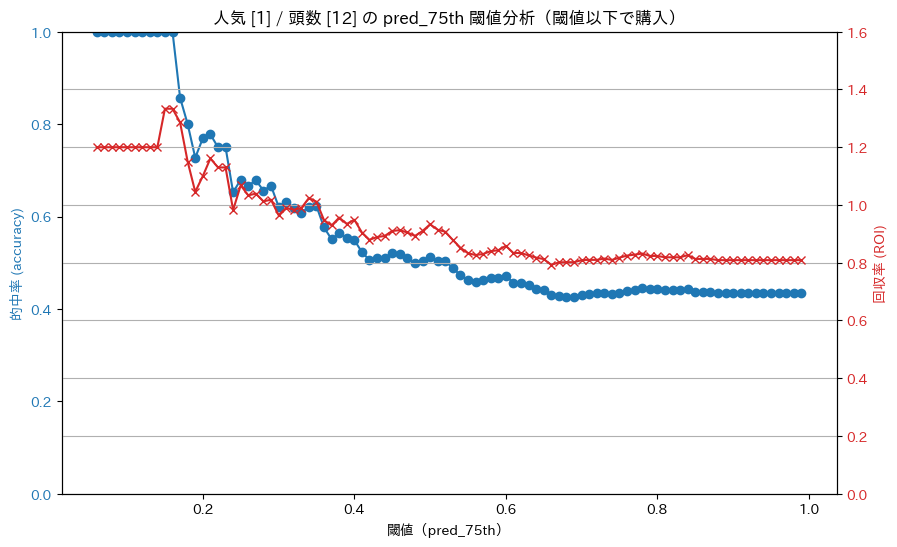

In [7]:
# -----------------------------
# 設定
# -----------------------------
target_popularity = [1]
target_percentile = 75
bet_amount = 100
thresholds = np.arange(0, 1.0, 0.01)
target_num_horses_list = [12]  # ←購入対象の頭数を指定可能（複数指定可）

accuracy_list = []
roi_list = []

# 指定人気・頭数・ランニングスタイルで抽出
df_pop = full_pred_df[
    (full_pred_df["popularity"].isin(target_popularity)) &
    (full_pred_df["running_style_type_past"] == "front") &
    (full_pred_df["num_horses"].isin(target_num_horses_list))
].copy()

# 閾値ごとに的中率・ROIを計算
for th in thresholds:
    df_bet = df_pop[df_pop[f"pred_{target_percentile}th"] <= th].copy()
    total_bets = len(df_bet)
    hits = (df_bet["finish_rank"] == 1).sum()
    total_payout = (df_bet["odds"] * bet_amount * (df_bet["finish_rank"] == 1)).sum()
    
    accuracy = hits / total_bets if total_bets > 0 else np.nan
    roi = total_payout / (total_bets * bet_amount) if total_bets > 0 else np.nan
    
    accuracy_list.append(accuracy)
    roi_list.append(roi)

# -----------------------------
# グラフ描画
# -----------------------------
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax1.set_xlabel(f"閾値（pred_{target_percentile}th）")
ax1.set_ylabel("的中率 (accuracy)", color=color)
ax1.plot(thresholds, accuracy_list, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("回収率 (ROI)", color=color)
roi_max = np.nanmax(roi_list)
if np.isnan(roi_max) or roi_max == 0:
    roi_max = 1.0
ax2.plot(thresholds, roi_list, color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, roi_max * 1.2)

plt.title(f"人気 {target_popularity} / 頭数 {target_num_horses_list} の pred_{target_percentile}th 閾値分析（閾値以下で購入）")
plt.grid(True)
plt.show()
